# Computer Vision - Lab 3
- **Name:** Shy Ohev Zion
- **ID:** 318783479

**<u>TL;DR</u>**<br>
- In this lab we've started discussing about different image augmentations. 
- In the lab section I've implemented 5 augmentations - flip, rotate, gaussian blur (filter), crop, and sharpen.
- In the final work section I have:
    - Optimised the rotataion (multiplication is <u>costly</u>. doing it once with meshgrid speeds up the rotation calculation)
    - Generated randomly augmented images via random number generation

## Imports, Configurations and Function Definitions (relevant for all sections)

In [1]:
import os
import cv2 as cv
import numpy as np
from PIL import Image
import scipy.stats as st
from scipy import ndimage

# a convenience method to itereate over adjacent pairs of an iterable.
# comes from the 'more-itertools' package.
from more_itertools import pairwise
from matplotlib import pyplot as plt

# a grid layout to place subplots within a figure
from matplotlib.gridspec import GridSpec
from scipy.signal import convolve, convolve2d
from sklearn.metrics import mean_squared_error as mse

global_rng = np.random.default_rng(42)  # for reproducibility purposes

data_dir_name = "data"
rgb_image_name = "demo_RGB_image.png"
house_name = "house.tiff"
rgb_image = cv.imread(os.path.join("..", data_dir_name, rgb_image_name))
house = cv.imread(os.path.join("..", data_dir_name, house_name))
gray_house = cv.cvtColor(house, cv.COLOR_BGR2GRAY)
house = cv.cvtColor(house, cv.COLOR_BGR2RGB)


# converting the GRB image to grayscale
rgb_gray = cv.cvtColor(rgb_image, cv.COLOR_BGR2GRAY)

## Preparatory Work

### Adding Gaussian Noise
[gaussian noise](https://en.wikipedia.org/wiki/Gaussian_noisehttps://en.wikipedia.org/wiki/Gaussian_noise) - a statistical noise having a probability density function equal to that of the normal distribution (a.k.a. gaussian distribution)

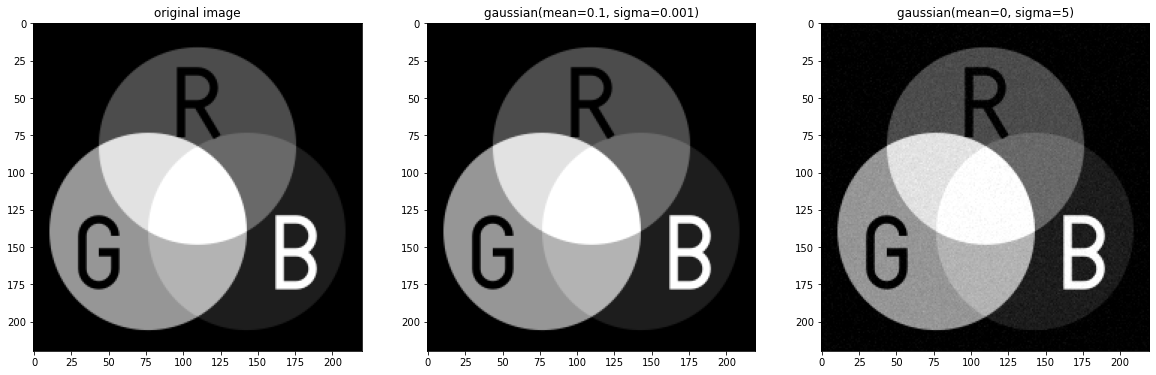

In [2]:
def add_guassian_noise(img: np.ndarray, mean: float, sigma: float) -> np.ndarray:
    noise = global_rng.normal(mean, sigma, img.shape)  # for reproducibility purposes
    noised_image = img + noise
    noised_image = np.clip(noised_image, 0, 255).astype(np.uint8)
    return noised_image


noisy1 = add_guassian_noise(rgb_gray, 0.1, 0.001)
noisy2 = add_guassian_noise(rgb_gray, 0, 5)

fig, (ax_orig, ax_noisy1, ax_noisy2) = plt.subplots(ncols=3, figsize=(20, 10))

ax_orig.set(title="original image")
ax_orig.imshow(rgb_gray, cmap="gray")

ax_noisy1.set(title="gaussian(mean=0.1, sigma=0.001)")
ax_noisy1.imshow(noisy1, cmap="gray")

ax_noisy2.set(title="gaussian(mean=0, sigma=5)")
ax_noisy2.imshow(noisy2, cmap="gray")

plt.show()

### Cleaning the Noise
After several attempts, a 'simple' gaussian kernel (same normal distribution as with the gaussian noise) seems to do a decent job at cleaning the noise, at the expense of blurriness

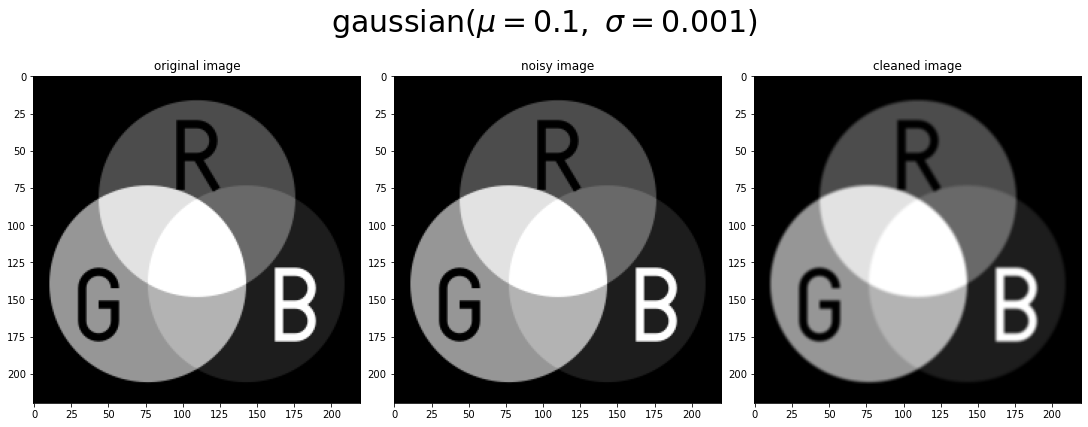

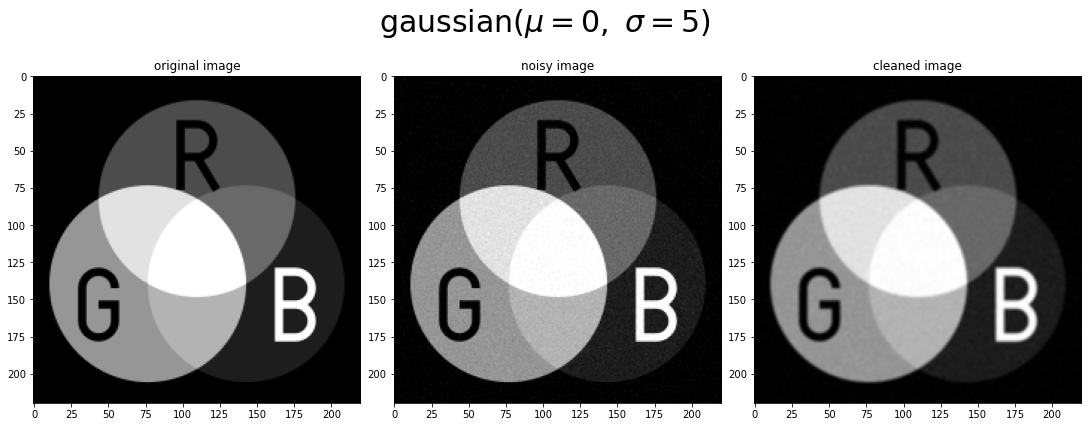

In [3]:
def remove_noise(img: np.ndarray, filter: np.ndarray) -> np.ndarray:
    clean_img = convolve2d(img, filter, mode="same", boundary="symm")
    np.clip(clean_img, 0, 255, clean_img)
    return clean_img.astype(np.uint8)


size = 3
edge = 1
x_vals = np.linspace(-edge, edge, size)
kern_1d = st.norm.pdf(x_vals)
kern_2d = np.outer(kern_1d, kern_1d)
gaussian = kern_2d / kern_2d.sum()

averaging = np.ones((size, size), dtype="float") * (1.0 / (size ** 2))

denoised1 = remove_noise(noisy1, gaussian)
denoised2 = remove_noise(noisy2, gaussian)


def display_original_noisy_cleaned(
    img: np.ndarray, noisy: np.ndarray, cleaned: np.ndarray, title: str
):
    fig, (ax_orig, ax_noisy, ax_denoised) = plt.subplots(
        ncols=3, figsize=(15, 6), constrained_layout=True
    )

    fig.suptitle(title, fontsize=30)

    ax_orig.set(title="original image")
    ax_orig.imshow(img, cmap="gray")

    ax_noisy.set(title="noisy image")
    ax_noisy.imshow(noisy, cmap="gray")

    ax_denoised.set(title="cleaned image")
    ax_denoised.imshow(cleaned, cmap="gray")

    plt.show()


display_original_noisy_cleaned(
    rgb_gray, noisy1, denoised1, "gaussian($\mu=0.1,\ \sigma=0.001)$"
)

display_original_noisy_cleaned(
    rgb_gray, noisy2, denoised2, "gaussian($\mu=0,\ \sigma=5)$"
)

### Comparing Between the Images

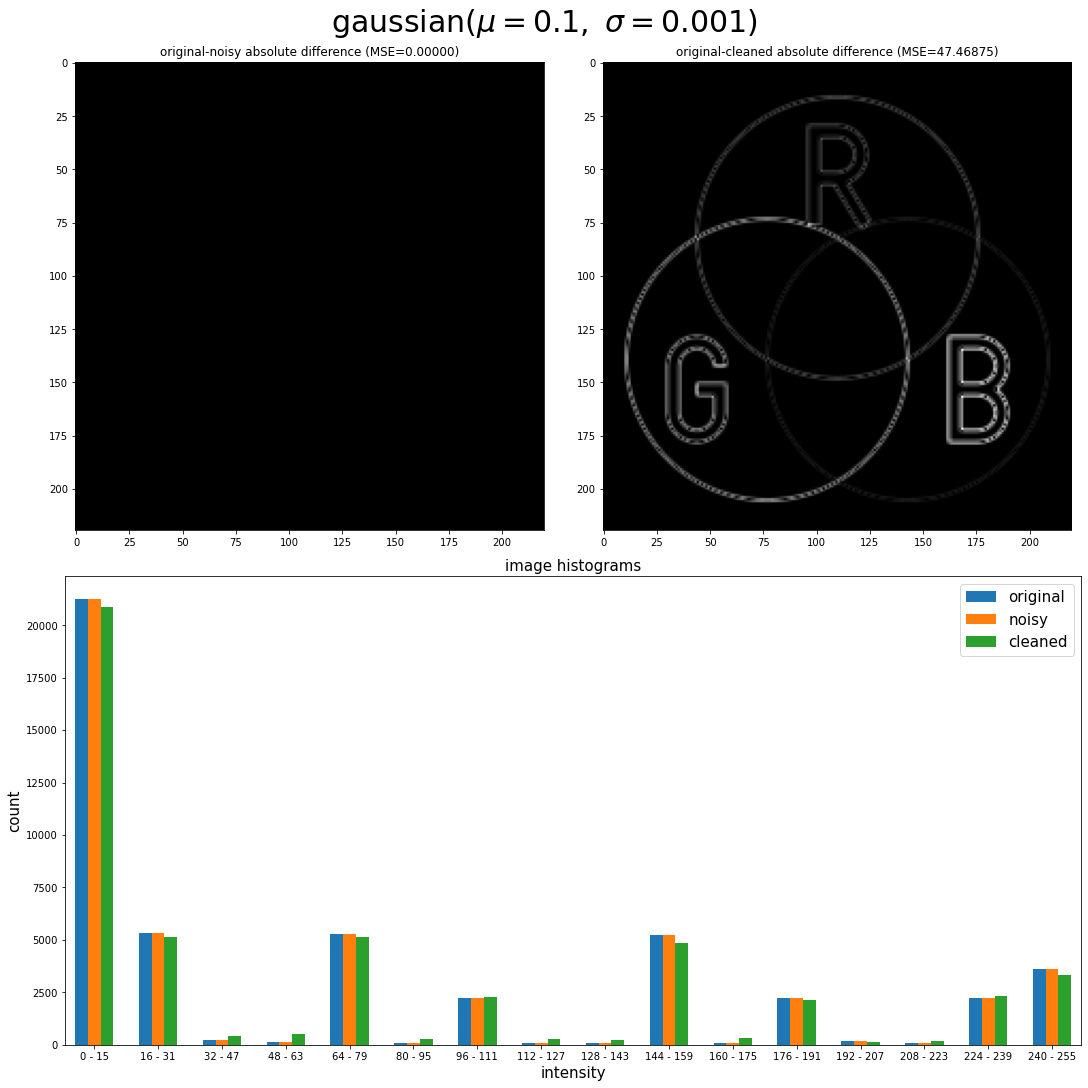

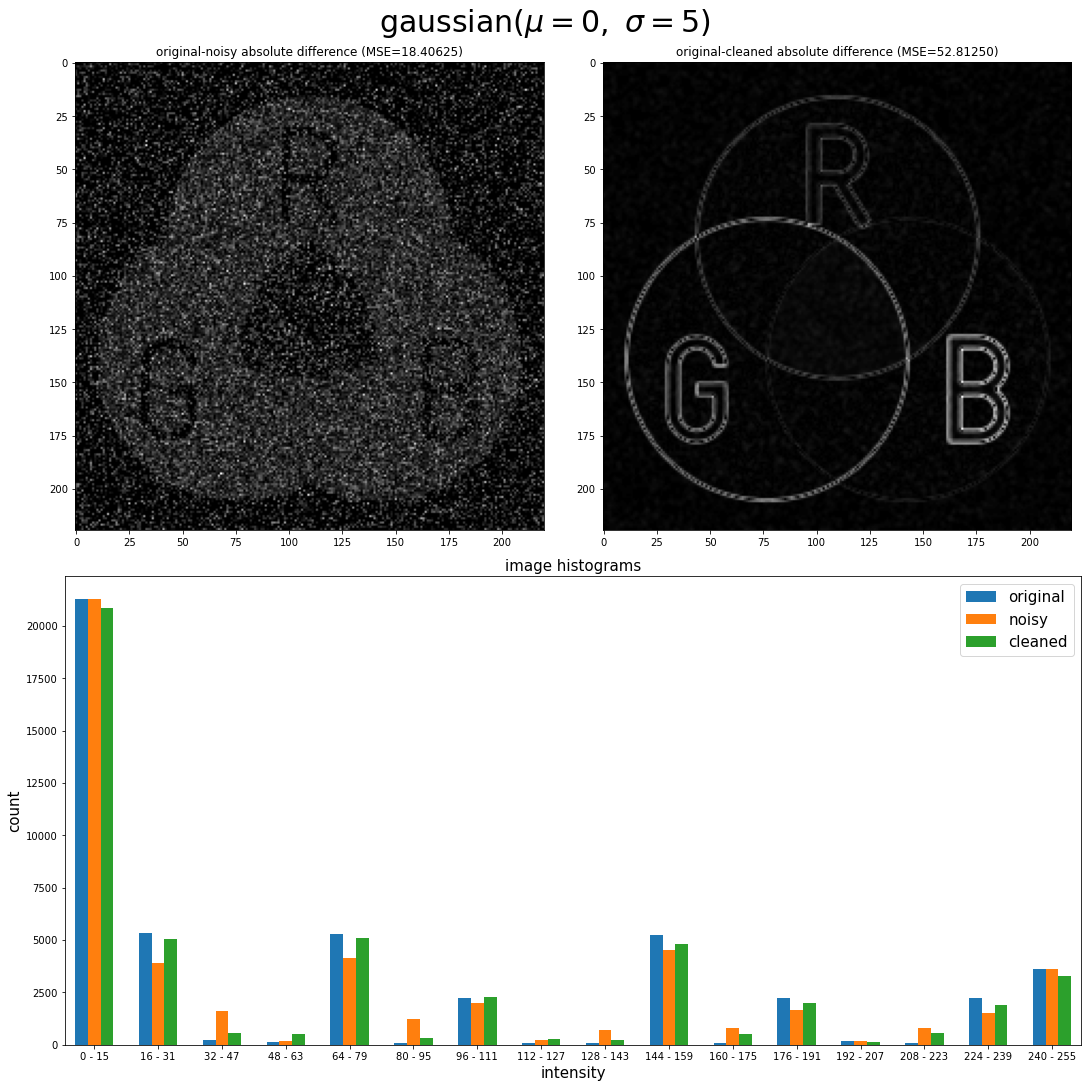

In [4]:
def display_statistical_comparison(
    img: np.ndarray, noisy: np.ndarray, cleaned: np.ndarray, title: str
):
    # type conversions are used to avoid integer overflow
    img_noisy_diff = np.clip(np.abs(img.astype(np.int16) - noisy), 0, 255).astype(
        np.uint8
    )
    img_cleaned_diff = np.clip(np.abs(img.astype(np.int16) - cleaned), 0, 255).astype(
        np.uint8
    )

    fig = plt.figure(figsize=(15, 15), constrained_layout=True)

    # defining a 2x2 grid to fit subplots in a figure
    gs = GridSpec(2, 2, figure=fig)

    ax_in_diff = fig.add_subplot(gs[0, 0])
    ax_ic_diff = fig.add_subplot(gs[0, 1])
    ax_hist = fig.add_subplot(gs[1, :])

    fig.suptitle(title, fontsize=30)

    # np.half - half percision (16-bit) floating point numbers
    # used to avoid rounding errors from uint8 that give inaccurate results
    ax_in_diff.set(
        title=f"original-noisy absolute difference (MSE={mse(img.astype(np.half), noisy):.5f})"
    )
    ax_in_diff.imshow(img_noisy_diff, cmap="gray")

    ax_ic_diff.set(
        title=f"original-cleaned absolute difference (MSE={mse(img.astype(np.half), cleaned):.5f})"
    )
    ax_ic_diff.imshow(img_cleaned_diff, cmap="gray")

    bar_width = 0.2
    index = np.linspace(0, 15, 16)

    # creating the histograms for each image
    hist, bin_edges = np.histogram(img, bins=16, range=(0, 256))
    ax_hist.bar(index - bar_width, hist, bar_width, label="original")

    hist, _ = np.histogram(noisy, bins=16, range=(0, 256))
    ax_hist.bar(index, hist, bar_width, label="noisy")

    hist, _ = np.histogram(cleaned, bins=16, range=(0, 256))
    ax_hist.bar(index + bar_width, hist, bar_width, label="cleaned")

    labels = [f"{a} - {b-1}" for a, b in pairwise(bin_edges.astype(int))]

    ax_hist.set_xlabel("intensity", fontsize=15)
    ax_hist.set_ylabel("count", fontsize=15)
    ax_hist.set_xticks(index, labels)
    ax_hist.set_title("image histograms", fontsize=15)
    ax_hist.margins(x=0.01)
    ax_hist.legend(loc="upper right", fontsize=15)

    plt.show()


display_statistical_comparison(
    rgb_gray, noisy1, denoised1, r"gaussian($\mu=0.1,\ \sigma=0.001)$"
)

display_statistical_comparison(
    rgb_gray, noisy2, denoised2, r"gaussian($\mu=0,\ \sigma=5)$"
)

#### Explaining the Results
- for the 'quieter' noise (with $\mu=0.1,\ \sigma=0.001$), the noisy image was actually the same image as the original(indicated by 'MSE=0') due to the 8-bit color representation and the way-too-small differences and rounding.<br>the 'cleaned' image is actually a smoothened version of the noisy (and the original), so the difference was to be expected, especially in the edges. (where there is noticable difference between neighboring pixels' intensity)

- for the 'louder' noise (with $\mu=0,\ \sigma=5)$, the increase in the MSE of the differences comes again as a result of smoothening, but it's apparent the absolute difference of the cleaned image is 'concentrated' on the edges instead of being dispersed everywhere - less noise overall, but 'louder'.

## Lab Work
this section includes implementing the following augmentations:
- Flip
- Rotate
- Gaussian-Blur
- Crop
- Sharpen

### Flip
applies random axis flip (either horizontal or vertical) each call; seed parameter is used for reproducibility

In [5]:
def flip_image(img: np.ndarray, seed: int = None, rng: np.random.Generator = None):
    if rng is None:
        rng = np.random.default_rng(seed)

    return np.flip(img, round(rng.random()))

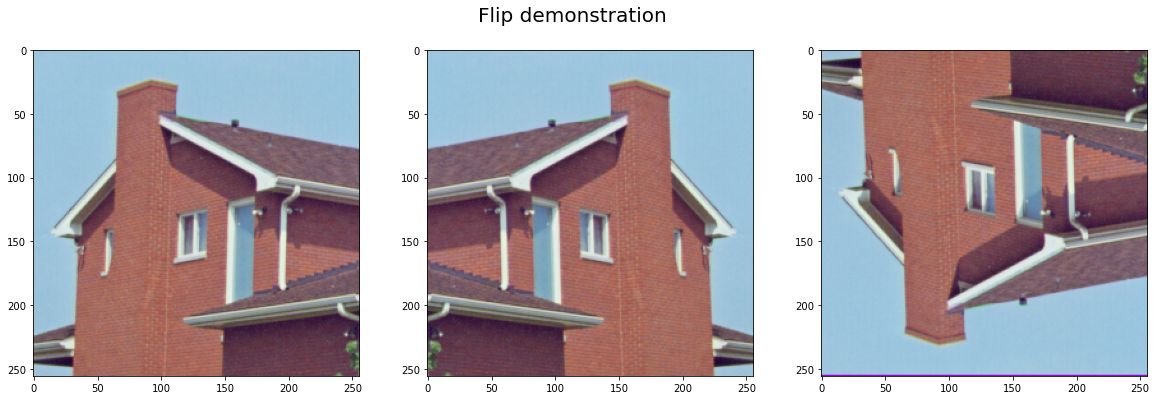

In [6]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=3)

axs[0].imshow(house)
axs[1].imshow(flip_image(house, rng=global_rng))
axs[2].imshow(flip_image(house, rng=global_rng))

fig.suptitle("Flip demonstration", fontsize=20)

plt.show()

### Rotate
The implementation follows [this article](https://homepages.inf.ed.ac.uk/rbf/HIPR2/rotate.htm).

The augmentation takes an image and an angle (<u>in radians</u>) and rotates the image counterclockwise by that angle. The rotation is calculated by it's 'inverse' - i.e., mapping the rotated image's pixels to those of the original image and applying the mapped pixels' values to the rotated image. <br>
Doing the calculation straightforward (and not by the reverse rotation) will cause a pattern of black pixels to appear due to rounding errors.

In [7]:
def get_rot_matrix(theta: float):
    cos, sin = np.cos(theta), np.sin(theta)
    return np.array(([cos, -sin], [sin, cos]), dtype=float)


def rotate_image(img: np.ndarray, theta: float):

    rows, cols = img.shape[:2]
    center = np.array([rows, cols]) / 2.0
    rotated = np.zeros(img.shape, dtype=np.uint8)

    rot_matrix = get_rot_matrix(-theta)
    for index, _ in np.ndenumerate(rotated):
        row, col = index[:2]
        index = np.array([row, col])
        prev_index = rot_matrix @ (index - center) + center  # @ - matrix multiplication

        prev_row, prev_col = prev_index.astype(int)
        if not 0 <= prev_row < rows:
            continue
        if not 0 <= prev_col < cols:
            continue

        val = img[prev_row, prev_col]
        rotated[row, col] = val

    return rotated

Wall time: 1.43 s


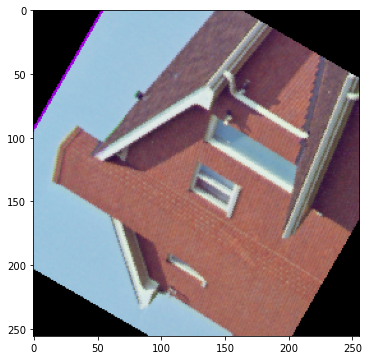

In [8]:
plt.figure(figsize=(6, 6))

%time plt.imshow(rotate_image(house, np.radians(60))) # 60 degrees counterclockwise rotation

plt.show()

Measureing the difference (MSE) between the implemented method and the `scipy` built-in method yields...

In [9]:
mse(
    rotate_image(house, np.radians(60)).flatten(),
    ndimage.rotate(house, 60, reshape=False).flatten(),
)

27.158060709635418

...A decent result, as the built-in method uses resampling methods to generate a 'better looking' rotated image, so minor differences are to be expected.

### Gaussian-Blur
takes `kernel_size` samples out of (`-val_range`, `val_range`) for each of the axes, and applying the gaussian (normal) distribution: 
$g(x,y)=\frac{1}{2\pi\sigma^2} \cdot e^{-\frac{x^2+y^2}{2\sigma^2}}$

In [10]:
def get_gaussian_filter(kernel_size: int, sigma: float, val_range: float = 1):
    vals = np.linspace(-val_range, val_range, kernel_size)
    xx, yy = np.meshgrid(vals, vals)
    denom = 2 * sigma ** 2
    gaussian = np.exp(-(xx ** 2 + yy ** 2) / (denom)) / (np.pi * denom)
    return gaussian

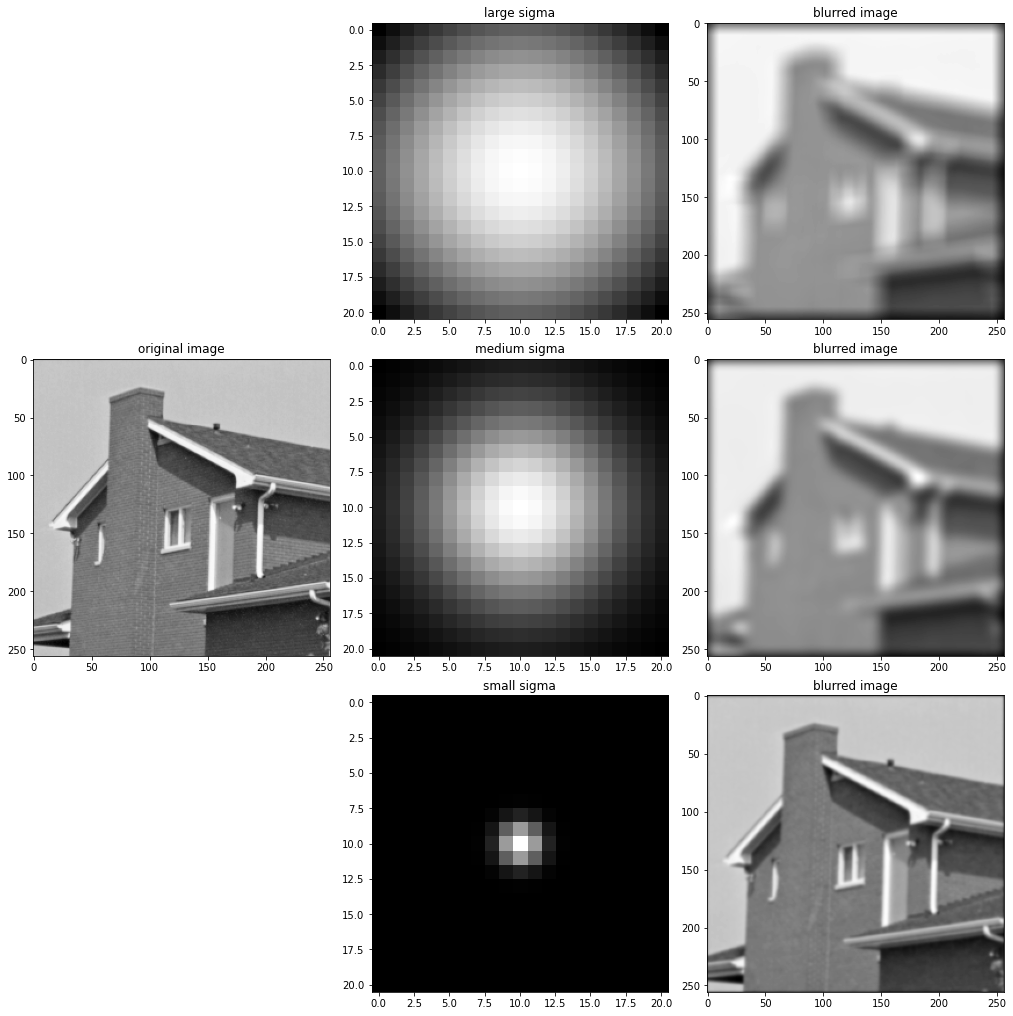

In [11]:
kernel_size = 21
sigma = [1, 0.5, 0.1]
size = ["large", "medium", "small"]

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = GridSpec(3, 3, figure=fig)
ax = fig.add_subplot(gs[1, 0])
ax.set_title("original image")
ax.imshow(gray_house, cmap="gray")

for i in [0, 1, 2]:
    gaussian_filter = get_gaussian_filter(kernel_size, sigma[i])
    gaussian_filter = gaussian_filter
    blurred = convolve2d(gray_house, gaussian_filter, mode="same")
    blurred = (255 * (blurred / blurred.max())).astype(np.uint8)
    ax = fig.add_subplot(gs[i, 1])
    ax.set_title(f"{size[i]} sigma")
    ax.imshow(gaussian_filter, cmap="gray")

    ax = fig.add_subplot(gs[i, 2])
    ax.set_title("blurred image")
    ax.imshow(blurred, cmap="gray")

plt.show()

### Crop

In [12]:
def crop_image(img: np.ndarray, x1: int, y1: int, x2: int, y2: int):
    if x2 < x1:
        x1, x2 = x2, x1
    if y2 < y1:
        y1, y2 = y2, y1
    return img[x1:x2, y1:y2]

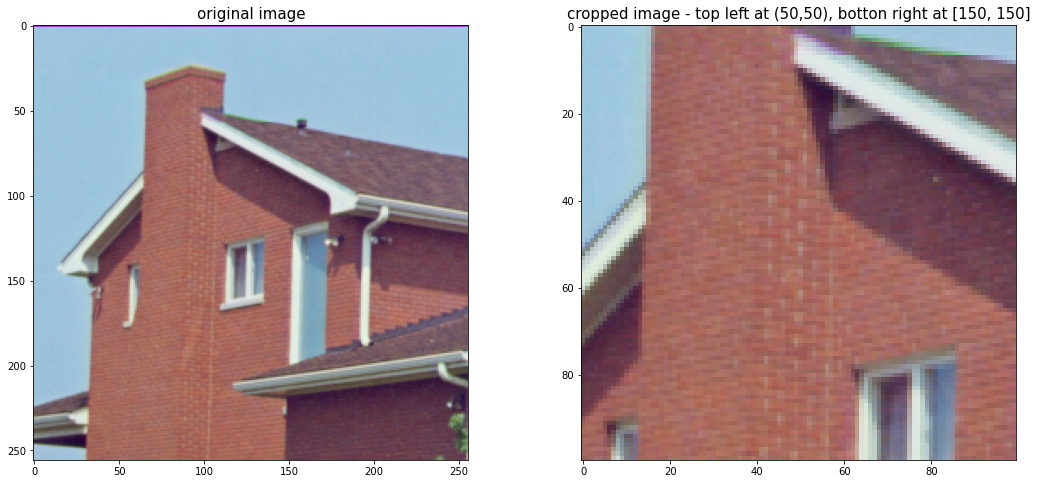

In [13]:
fig, (ax_original, ax_cropped) = plt.subplots(figsize=(18, 8), ncols=2)

ax_original.set_title("original image", fontsize=15)
ax_original.imshow(house)

ax_cropped.set_title(
    "cropped image - top left at (50,50), botton right at [150, 150]", fontsize=15
)
ax_cropped.imshow(crop_image(house, 50, 50, 150, 150))

plt.show()

### Sharpen
as taught in class, convolving the image with the matrix $\frac{1}{9}\cdot\begin{bmatrix} -1 & -1 & -1 \\ -1 & 17 & -1 \\ -1 & -1 & -1 \end{bmatrix}$ yields a sharpening effect - the original image overlaid with a high pass filter (HPF) result

In [14]:
def sharpen_image(img: np.ndarray):
    if img.ndim != 2:
        raise ValueError("2D (grayscale) images only")

    sharpening_matrix = (1 / 9) * np.array([[-1, -1, -1], [-1, 17, -1], [-1, -1, -1]])
    sharpened = convolve2d(img, sharpening_matrix, mode="same")
    sharpened = (255 * (sharpened / sharpened.max())).astype(np.uint8)
    return sharpened

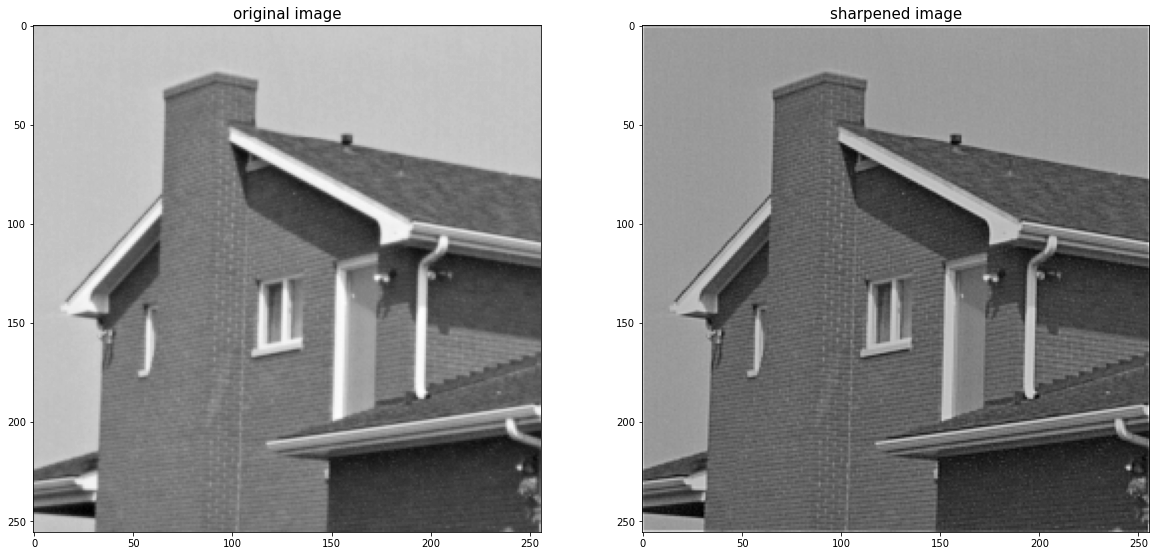

In [15]:
fig, (ax_original, ax_sharpened) = plt.subplots(ncols=2, figsize=(20, 14))

ax_original.set_title("original image", fontsize=15)
ax_original.imshow(gray_house, cmap="gray")

ax_sharpened.set_title("sharpened image", fontsize=15)
ax_sharpened.imshow(sharpen_image(gray_house), cmap="gray")

plt.show()

## Final Work

### Generation randomly augmented images
Starting with the 'original' house image, for each image, each augmentation is either applied or not (probability 0.5), in the following order:
1. (F)lip
1. (R)otate (with randomized `theta` between 0 and $2\pi$)
1. (G)aussian Blur (with `kernel_size`=21 and `sigma` randomized between 0.1 and 1)
1. (C)rop (around the center, with randomized ratio between 0.3 and 1)
1. (S)harpen

Each image will have the applied transformation's initial as part of the title

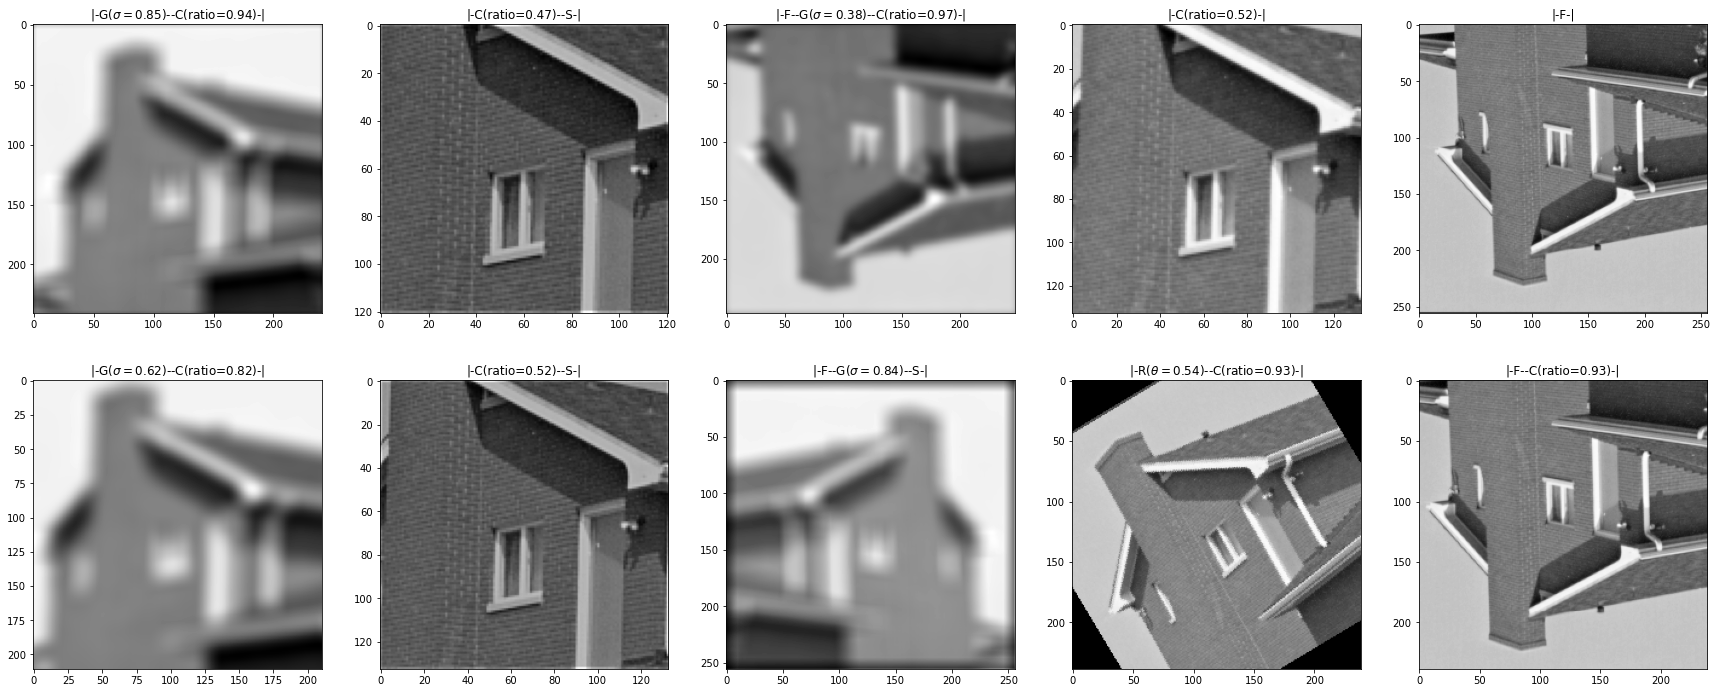

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 12))

for ax in np.reshape(axs, 10):
    augmented = gray_house
    title = "|"
    options = global_rng.integers(2, size=5)
    while not any(options):
        options = global_rng.integers(2, size=5)

    if options[0]:
        augmented = flip_image(augmented, rng=global_rng)
        title += "-F-"

    if options[1]:
        theta = np.radians(global_rng.integers(360))
        augmented = rotate_image(augmented, theta)
        title += fr"-R($\theta={theta:.2f}$)-"

    if options[2]:
        sigma = (1 - 0.1) * global_rng.random() + 0.1
        gaussian_filter = get_gaussian_filter(kernel_size=21, sigma=sigma)
        augmented = convolve2d(augmented, gaussian_filter, mode="same")
        title += fr"-G($\sigma={sigma:.2f}$)-"

    if options[3]:
        ratio = (1 - 0.3) * global_rng.random() + 0.3
        shape = np.array(augmented.shape)
        top_left = ((1 - ratio) * shape / 2).astype(int)
        bottom_right = ((1 + ratio) * shape / 2).astype(int)
        augmented = crop_image(
            augmented, top_left[0], top_left[1], bottom_right[0], bottom_right[1]
        )
        title += f"-C(ratio={ratio:.2f})-"

    if options[4]:
        augmented = sharpen_image(augmented)
        title += "-S-"

    title += "|"

    ax.imshow(augmented, cmap="gray")
    ax.set_title(title)

plt.show()

### Optimizing the rotate function
this implementation is ~4 times faster than the original `rotate_image` implementation; it uses `np.meshgrid` to first generate all origin indices (inverse computation) and the loop only checks if they're valid indices; this implementation is still around an order of magnitude slower than `scipy.ndimage.rotate`.

In [17]:
def optimized_rotate_image(img, theta):

    rows, cols = img.shape[:2]
    center = np.array([rows, cols]) / 2.0

    x = np.arange(rows) - center[0]
    y = np.arange(cols) - center[1]

    xx, yy = np.meshgrid(x, y)

    cos, sin = np.cos(-theta), np.sin(-theta)

    xx_transformed = cos * xx - sin * yy + center[0]
    xx_transformed = xx_transformed.astype(int)

    yy_transformed = sin * xx + cos * yy + center[1]
    yy_transformed = yy_transformed.astype(int)

    rotated = np.zeros(img.shape, dtype=np.uint8)

    for index, _ in np.ndenumerate(rotated):
        row, col = index[:2]
        prev_row = xx_transformed[col, row]
        prev_col = yy_transformed[col, row]
        if 0 <= prev_row < rows and 0 <= prev_col < cols:
            rotated[row, col] = img[prev_row, prev_col]

    return rotated

Hopefully there shouldn't be any difference in the results - the MSE will tell us that:

In [18]:
mse(
    rotate_image(house, np.radians(60)).flatten(),
    optimized_rotate_image(house, np.radians(60)).flatten()
)

0.0

The average runtimes of the three methods:

In [19]:
%timeit rotate_image(house, np.radians(60))

%timeit optimized_rotate_image(house, np.radians(60))

%timeit ndimage.rotate(house, 60, reshape=False)

1.41 s ± 19.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
330 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.3 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
